In [15]:
import matplotlib.pyplot as mp
import numpy as np
import metpy.calc as mpc
import xarray as xr
import datetime as dt

##### SCAM FORCINGS GENERATION FOR SAS PARAMETERS IN #####
### http://www2.mmm.ucar.edu/people/patton/documents/su_et_al.ACP.2016.pdf ###

## Time ##

bdate = 20130610

spd = 86400 # Seconds per day
sph = 3600  # Seconds per hour
mpd = 1440  # Mins per day
spm = 60    # Seconds per minute.

dtime = 1*spm    # Time interval (minutes*60=sec) for each time point on file (does not have to be DTIME)
tperiod = (16.5-6)*sph    # Time length (hours*sph=sec) for whole of IOP
iop_zstart = 12*sph  # 12Z = 6AM MST (US)

iop_lat = 32.5 # Lat location (SAS average of two smapling sites)
iop_lon = -87.15 # Lon

lno_lsf = True # Set large scale forcings to zero.

vdesc = ('Initial BL height', \
         'Subsidence rate', \
         'Surface sensible heat flux',\
         'Surface latent heat flux',\
         'Entrainment/surface heat flux ratio'\
         'Initial BL potential temperature',\
         'Initial FT potential temperature',\
         'Potential temperature lapse rate FT',\
         'Advection of potential temperature',\
         'Initial BL specific humidity',\
         'Initial FT specific humidity',\
         'Specific humidity lapse rate FT',\
         'Advection of specific humidity')


vname = ('pblh','w_sub','shflx','lhflx','eratio','the_bl','the_trop','the_lr','the_adv','q_bl','q_trop','q_lr','q_adv')
#vval =  (500,    9.e-6,   0.1,   0.15,    0.2,     296.6,   298.1,     0.003,   6.40e-4, 16.8,    12.8,   -0.004,   1.5e-4) # paper values
vval =  (500,    9.e-6,   0.1,   0.15,    0.2,     296.6,   298.1,     0.003,   6.40e-4, 16.8,    12.8,   -0.004,   1.5e-4) # paper values


##############################


##### IOP file info. ######
iop_file_in = './ARM95_4scam_c180703.nc'   # input template
iop_file_out = './SAS_ideal_4scam_03.nc' # Output forcing file

## Read in and IOP template
iop_in = xr.open_dataset(iop_file_in,engine='netcdf4') # This is like addfile -> pointer

### Copy IOP 'DataSet' ##
iop_out = iop_in

## Clean out existing variables and obsolete attributes ##
iop_out = iop_in.drop(iop_in.data_vars)
del(iop_out.attrs['history'])
del(iop_out.attrs['nco_openmp_thread_number']) 
del(iop_out.attrs['NCO'])
print(iop_out)
## Fill out known info. now ##
iop_out['lon'] = [np.float32(iop_lon)] # need [] here so it gets treated as a 0d array coordinate
iop_out['lat'] = [np.float32(iop_lat)]
iop_out.lat.attrs = iop_in.lat.attrs
iop_out.lon.attrs = iop_in.lon.attrs



## Add Time (tsec) Array Based on time information ##
ntsteps = int(tperiod/dtime)
time = iop_zstart+dtime*np.arange(ntsteps)

## Copy attributes of tsec from iop_in ##
iop_out.coords['tsec'] = ('time', time)
iop_out.tsec.attrs['long_name'] = iop_in.tsec.attrs['long_name'] 
iop_out.tsec.attrs['units'] = iop_in.tsec.attrs['units'] 
iop_out['bdate'] = bdate

## Open New IOP/netcdf/DataSet and add attributes ##
iop_out.attrs['title'] = 'Southeast Atmosphere Study (SAS) campaign: Ideal day for the Mixed Layer Model (MXLCH, it can be accessed athttps://github.com/classmodel/mxlch)'
iop_out.attrs['iop_file'] = iop_file_out
iop_out.attrs['publication'] = 'https://doi.org/10.5194/acp-16-7725-2016'
iop_out.attrs['creation_date'] = str(dt.datetime.today())
iop_out.attrs['creation_date'] = 'Rich Neale, NCAR'

## Set up a basoiope 3D/4D DataArray that will be written into the new DataSet
var_4d = np.zeros((ntsteps,18,1,1),dtype=np.float32) # Set-up
var_3d = np.zeros((ntsteps,1,1),  dtype=np.float32) # Set-up

iop_out_c4 = ('time','lev','lat','lon')   # Coordinates for iop_out
iop_out_c3 = ('time','lat','lon')



                 

<xarray.Dataset>
Dimensions:  (lat: 1, lev: 18, lon: 1)
Coordinates:
  * lon      (lon) float32 -97.49
  * lat      (lat) float32 36.61
  * lev      (lev) float32 11500.0 16500.0 21500.0 ... 86500.0 91500.0 96500.0
Data variables:
    *empty*
Attributes:
    title:          arm0795_ebbr.nc
    missing_value:  -9999.0


In [19]:
### Need constants ###

r_gas = 287.   # Specific gas constant for dry air
cp_air = 1004.6 # Specific heat for dry air
Lv = 2.501e6      # Latent heat of vaporization

r_cp = r_gas/cp_air    # r/cp
grav = 9.81     # Gravity ave.


                        
###### Construct time varying data for 3d arrays (time,lat,lon) ######

## Generate boundary forced variables ##
shflx0 = vval[vname.index('shflx')]
vdesc_i = vdesc[vname.index('shflx')]
print(shflx0)

lhflx0 = vval[vname.index('lhflx')]
vdesc_i = vdesc[vname.index('lhflx')]
print(lhflx0)
## SAS case study: Daylight variation of sfce fluxes (sfc fluxes to be converted to energy flux) ##
shflx = np.copy(var_3d)  
shflx[:,0,0] = shflx0*cp_air*np.sin(np.pi*(time-iop_zstart)/tperiod)
iop_out['shflx'] = (iop_out_c3, shflx)
#iop1_out = xr.Dataset({'shflx': (['lon', 'lat', 'tsec'],  shflx),
                     coords={'lon': ('lon','lon'), 'lat'lat: (['], lat})
#iop_out1 = xr.Dataset(data_vars={"temperature: da_temperature, "pressure": da_pressure})
print(iop_out)

lhflx = np.copy(var_3d)  
lhflx[:,0,0] = 0.001*lhflx0*Lv*np.sin(np.pi*(time-iop_zstart)/tperiod) # Convert g/kg -> kg/kg
iop_out['lhflx'] = (iop_out_c3, lhflx)


## Quick plots ##

fig,ax = mp.subplots(nrows=1, ncols=2,figsize=(12, 5))
fig.suptitle('lhflx/shflx')
ax[0].plot((time/sph)-6,lhflx[:,0,0])
ax[1].plot((time/sph)-6,shflx[:,0,0])



0.1
0.15


MissingDimensionsError: cannot set variable 'shflx' with 3-dimensional data without explicit dimension names. Pass a tuple of (dims, data) instead.

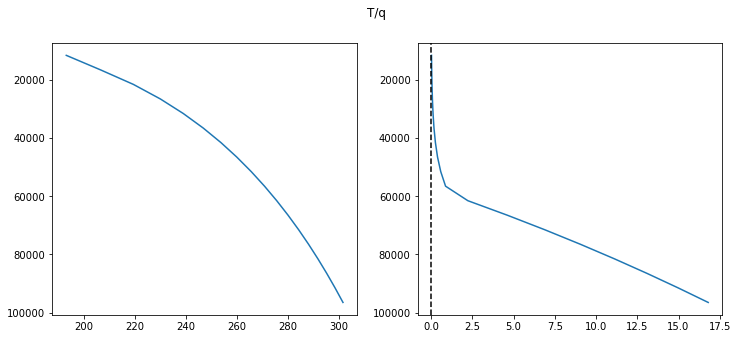

In [7]:
### Constructing vertical profiles ###
## Read in SCAM IOP template here (split into a function at some point)
#plevs = np.array([10, 20, 100, 150, 200, 300, 400, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 975, 1000])
#plevs = np.arange(10,1000,10)


## Convert trop theta values into temperature given plevs ##
plevs = iop_in['lev']

nplevs = np.size(plevs)
ps = 101500. # psurf [pa]
p0 = 100000. # pref [pa]

## Z of plevels, tricky don't have T yet ##
dp_levs = np.diff(plevs)


##### Construct profile ICs #######

## 1. Grab CASE values ##
pblh =  vval[vname.index('pblh')]

the_ft = vval[vname.index('the_trop')]
the_bl = vval[vname.index('the_bl')]
dthedp_ft =  vval[vname.index('the_lr')]

q_ft = vval[vname.index('q_trop')]
q_bl = vval[vname.index('q_bl')]
dqdp_ft = vval[vname.index('q_lr')]



## 2. Find PBL top level ##

# Temperature profile based just on the_bl
t_bl = the_bl*(plevs/p0)**r_cp  

# Assumed t is just below 800mb
p_bl_top = 80000. # hpa estimate pf PBL top.
t_bl_ave = np.average(t_bl[np.where(plevs >= p_bl_top)])

# Z levels based on t_bl
z_plevs = (r_gas/grav)*t_bl*np.log(ps/plevs)

# Where's the PBL?
ipbl_levs = np.where(z_plevs <= pblh)
npbl_levs = np.size(ipbl_levs)
nft_levs = nplevs-npbl_levs

ipbl_min = np.amin(ipbl_levs)


## 3. Use Gradient+mean and specified theta, q for profiles ##

q_plevs = np.full(nplevs, q_bl)
the = np.full(nplevs, the_bl) # Initialize theta pbl as numpys

# Construct profiles in the FT, starting at ipbl+ and working up

for ip in range(ipbl_min-1,-1,-1):
#    print("LEV --> ",ip,plevs[ip].data)
    
    # Temp profile
    t_ip = the[ip-1]*(plevs[ip-1]/p0)**r_cp # Temp at the level below
    rho = plevs[ip]/(r_gas*t_ip)  # Density at lev-=ip
    dz = dp_levs[ip]/(rho*grav)
    the[ip] = the[ip+1]+dthedp_ft*dz

#    print("T ->",t_ip.data,rho.data,dz.data,the[ip])
    
    # q profile 
 
    q_plevs[ip] = q_plevs[ip+1]+dqdp_ft*dz

#    print("q ->",q_plevs[ip],dz.data,dqdp_ft*dz.data)
#    print("")

## Set temp
temp_plevs = 8+the*(plevs/p0)**r_cp

## Don't let q go below a minimum (linear gradient will do that), or tail the value expoentially
#q_plevs[np.where(q_plevs <= 0)] = 0.1

## Exponential tailing 

ip0 = np.where(q_plevs <= 0)
ip0m = np.max(ip0)+1
ew = np.exp((plevs[ip0m]-plevs[ip0])/plevs[ip0m]) # Exponential weights 
ew = ew[::-1] # flip weights due to order of 
ew = (ew/np.exp([1]))**5 # Normaliz to 1 and **2 for stronger tailing at lower pressure 
q_plevs[ip0] = q_plevs[ip0m]*ew

## Quick plots ##

fig1,axs = mp.subplots(nrows=1, ncols=2,figsize=(12, 5))
fig1.suptitle('T/q')
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[0].plot(temp_plevs.transpose(), plevs)
axs[1].plot(q_plevs.transpose(), plevs)
axs[1].axvline(0, color='black',linestyle="--")



#z_plevs = (r_gas/grav)*np.mean(temp_plevs)*np.log(ps/plevs)

In [34]:
## Other profile arrays which are easy array copies ##



## Write out data to iop fiel 4d array structure, just copying initial temp to all times ##

# Constant value copying

# Omega (units are /s which don't make sense, maybe m/s)
w_sub = vval[vname.index('w_sub')]
omega = np.copy(var_4d) # Copy 4D array

# divt and divq (horizontal advection)
q_adv = vval[vname.index('q_adv')]
the_adv = vval[vname.index('the_adv')]

divT = np.copy(var_4d) # Copy 4D array, need to convert to Temp in the array u.del(the)->u.del(T)
divq = np.full_like(var_4d,0.001*q_adv) # Single value overwrite everywhere, convert g/kg/s->kg/kg/s

# Calculated above
T = np.copy(var_4d)  
q = np.copy(var_4d) 


for it in range(0, ntsteps):
   T[it,:,0,0] = temp_plevs.data[:]
   q[it,:,0,0] = q_plevs.data[:]
   divT[it,:,0,0] = the_adv*(plevs/p0)**r_cp # Constant in theta bbut not in T.

   rho = plevs/(r_gas*t_ip)  # Convert dw/dz -> dw/dp
   omega[it,:,0,0] = w_sub/(rho*grav)

## Write to IOP file ##

# 3D
iop_out['lhflx'] = (iop_out_c3, lhflx)
iop_out.lhflx.attrs = iop_in.lhflx.attrs 

iop_out['shflx'] = (iop_out_c3, shflx)
iop_out.shflx.attrs = iop_in.shflx.attrs 

# 4D
iop_out['T'] = (iop_out_c4, T)
iop_out['q'] = (iop_out_c4, np.float_(q/1000.)) # Funny SCAM requirments

if lno_lsf: # Set ls forcings to zero
    divq.fill(0.) ; divT.fill(0.) ; omega.fill(0.)
    
iop_out['divq'] = (iop_out_c4, divq)
iop_out['divT'] = (iop_out_c4, divT)
iop_out['omega'] = (iop_out_c4, omega)

for iv in iop_out.data_vars:
    iop_out[iv].attrs = iop_in[iv].attrs 
    print(iop_in[iv].attrs)
    iop_out[iv].attrs['_FillValue'] = -9999.
    iop_out[iv].attrs['missing_value'] = -9999. 



# Send everything to output IOP file
iop_out.to_netcdf(iop_file_out)



OrderedDict([('long_name', 'Base date as 6 digit integer'), ('units', 'yymmdd')])
OrderedDict([('long_name', 'Surface Sensible Heat Flux'), ('units', 'W/m2')])
OrderedDict([('long_name', 'Surface Latent Heat Flux'), ('units', 'W/m2')])
OrderedDict([('long_name', 'Temperature'), ('units', 'K')])
OrderedDict([('long_name', 'W.V. Mixing Ratio'), ('units', 'kg/kg')])
OrderedDict([('long_name', 'Horizontal Q Advective Tendency'), ('units', 'kg/kg/s')])
OrderedDict([('long_name', 'Horizontal T Advective Tendency'), ('units', 'K/s')])
OrderedDict([('long_name', 'Vertical Pressure Velocity'), ('units', 'Pa/s')])
